## Final Activity 2

MegaTon Bank would like to gain insight on their customers. They aim to discover what type of saving plans, money management, loans, and other types of services they can recommend. For this, they collected the usage behavior and debt information of their active credit card holders. The debtData.csv dataset presents the attributes of credit card holders. This dataset can be used for customer segmentation to define a marketing strategy.

Create a clustering model for the given dataset. The dataset has the following columns:
- CustomerID
- Age
- EducationLevel
- YearsEmployed
- Income - in thousands per month
- CardDebt
- OtherDebt
- Defaulted - failed to pay the minimum payment of existing debt
- DebtIncomeRatio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
data = pd.read_csv('data/debtData.csv')

# Handle missing values in 'Defaulted' by imputing with the mode
data['Defaulted'].fillna(0, inplace=True)

# Select features for clustering (exclude CustomerID)
data = data.drop('CustomerID', axis=1)
data = data.drop('DebtIncomeRatio', axis=1)

categorical_features = data[['EducationLevel', 'Defaulted']]

for col in ['Income', 'CardDebt', 'OtherDebt']:
    data[col] = np.log1p(data[col])  # log(x+1) to handle zeros

features = data[['Age', 'YearsEmployed', 'Income', 'CardDebt', 'OtherDebt']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Assign column names to the scaled features
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

data = pd.concat([categorical_features, scaled_features], axis=1)

data

,EducationLevel,Defaulted,Age,YearsEmployed,Income,CardDebt,OtherDebt
0,2,0.0,0.742915,-0.378790,-1.154930,-1.155634,-0.725413
1,1,0.0,1.489490,2.573721,1.628014,1.733823,1.657614
2,2,1.0,-0.252518,0.211712,0.674792,2.170302,1.172210
3,2,0.0,-0.750235,-0.674041,-1.154930,-0.429967,-1.225158
4,1,0.0,1.489490,3.311849,3.212853,2.839686,1.772895
...,...,...,...,...,...,...,...
845,1,0.0,-0.999093,-0.526415,-0.639196,-0.578573,-0.616000
846,2,0.0,-0.874664,-0.231164,-0.193222,-0.813340,-0.123986
847,4,1.0,-1.247951,-1.264543,-1.243079,1.041465,0.406029
848,1,0.0,-0.376947,0.506963,-0.516392,-1.168512,-1.045976


### WCSS

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


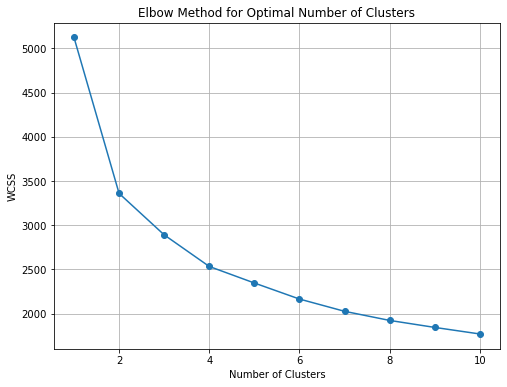

In [2]:
# WCSS Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Plot Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

### Silhouette Coefficient

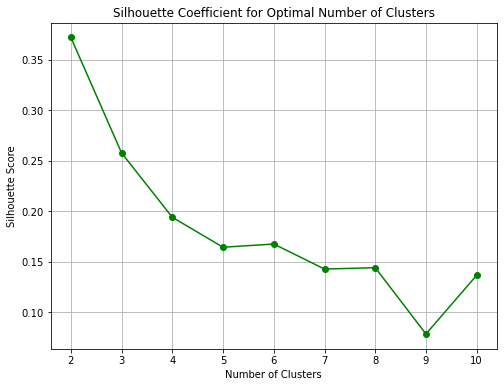

In [3]:
# Silhouette Coefficient
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_
    score = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(score)

# Plot Silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.title('Silhouette Coefficient for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()